In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from xgboost import XGBRegressor,plot_importance
from sklearn import preprocessing,pipeline,linear_model,neural_network,model_selection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("RestaurantVisitors.csv",parse_dates=True,index_col = "date")

In [3]:
df.index.freq = 'D'

In [4]:
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', name='date', length=517, freq='D')

In [5]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [6]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [7]:
df1.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [8]:
cols = ['rest1', 'rest2', 'rest3','rest4', 'total']
for col in cols:
    df1[col] = df1[col].astype(int)

In [9]:
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


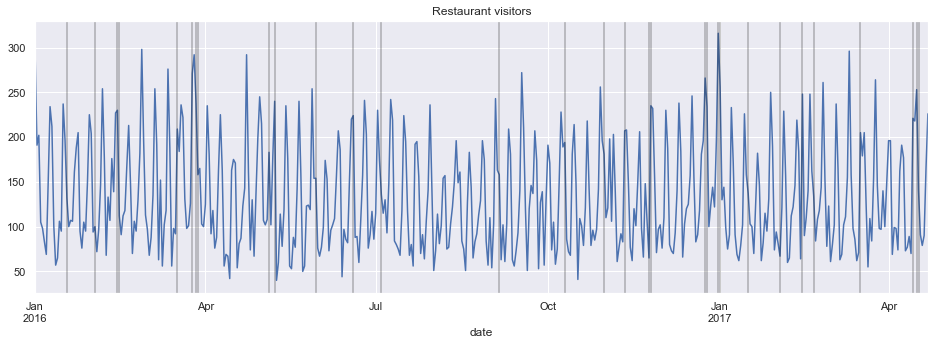

In [10]:
#holidays
title = "Restaurant visitors"
ylabel = "visitors per day"

ax = df1['total'].plot(figsize =(16,5),title = title)

for hol in df1.query("holiday==1").index:
    ax.axvline(x= hol,color = 'k',alpha = 0.3)


## run an ETS decomposition

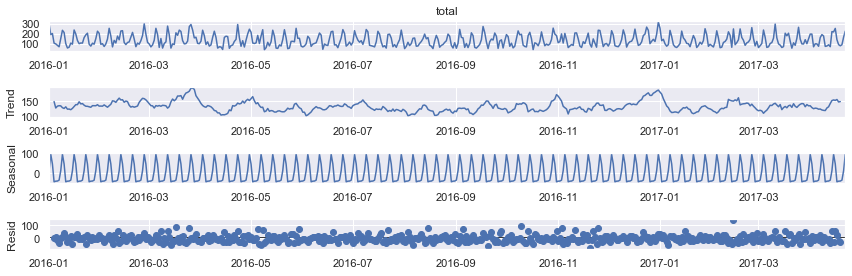

In [11]:
plt.rcParams["figure.figsize"]  = [12,4]
result = seasonal_decompose(df1['total'])
result.plot();

### Test for stationarity

In [12]:
def adf_fuller(series,title = ''):
    print(f'The augmented dickey fuller test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    
    out = pd.Series(result[0:4],index = labels)
    
    for key,val in result[4].items():
        
         out[f'the critical value ({key})'] = val
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    

In [13]:
adf_fuller(df1['total'])

The augmented dickey fuller test: 
ADF test statistic           -5.592497
p-value                       0.000001
# lags used                  18.000000
# observations              459.000000
the critical value (1%)      -3.444677
the critical value (5%)      -2.867857
the critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [14]:
auto_arima(df1['total'],seasonal = True,m = 7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2390.370
Date:                   Wed, 17 Feb 2021   AIC                           4788.739
Time:                           17:55:17   BIC                           4805.418
Sample:                                0   HQIC                          4795.297
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.8963      2.075      3.323      0.001       2.829      10.964
ar.S.L7        0.9462      0.016     59.645      0.000       0.915       0.977
ma.S.L7       -0.7081      0.053    -13.355      0.000      -0.812      -0.604
sigma2      1267.3341     77.842     16.281      0.000    1114.767    1419.901
===================================================================================
Ljung-Box (Q):                       77.21   Jarque-Bera (JB):                55.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.72
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
len(df1) # we will have 42 days to test so that it has several holidays

478

In [20]:
train = df1.iloc[:436]
test = df1.iloc[436:]

In [22]:
model  =SARIMAX(train['total'],order = (0,0,0),seasonal_order= (2,0,1,7),enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(2, 0, [1], 7)   Log Likelihood               -2165.136
Date:                   Wed, 17 Feb 2021   AIC                           4338.273
Time:                           18:15:54   BIC                           4354.583
Sample:                       01-01-2016   HQIC                          4344.710
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.0370      0.051     20.196      0.000       0.936       1.138
ar.S.L14      -0.0371      0.051     -0.722      0.470      -0.138       0.064
ma.S.L7       -0.9462      0.025    -38.559      0.000      -0.994      -0.898
sigma2      1109.4324     59.093     18.774      0.000     993.612    1225.252
===================================================================================
Ljung-Box (Q):                       64.28   Jarque-Bera (JB):                84.18
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
len(train)

436

In [24]:
len(test)

42

In [25]:
start = len(train)
end = len(train) + len(test)-1
predictions = result.predict(start = start,end = end,dynamic= False).rename('SARIMA(0,0,0)(2,0,[1],7) Predictions')

In [26]:
predictions

2017-03-12    172.455431
2017-03-13     87.190036
2017-03-14     97.858401
2017-03-15     96.852184
2017-03-16     99.113487
2017-03-17    141.868951
2017-03-18    236.993374
2017-03-19    172.754946
2017-03-20     88.079376
2017-03-21     98.919865
2017-03-22     96.653702
2017-03-23     98.665138
2017-03-24    141.371071
2017-03-25    234.788072
2017-03-26    172.752237
2017-03-27     88.105290
2017-03-28     98.951289
2017-03-29     96.638623
2017-03-30     98.640639
2017-03-31    141.341324
2017-04-01    234.687595
2017-04-02    172.738330
2017-04-03     88.099208
2017-04-04     98.944545
2017-04-05     96.630341
2017-04-06     98.631848
2017-04-07    141.328926
2017-04-08    234.665115
2017-04-09    172.724009
2017-04-10     88.091942
2017-04-11     98.936388
2017-04-12     96.622311
2017-04-13     98.623640
2017-04-14    141.317171
2017-04-15    234.645528
2017-04-16    172.709674
2017-04-17     88.084632
2017-04-18     98.928178
2017-04-19     96.614292
2017-04-20     98.615453


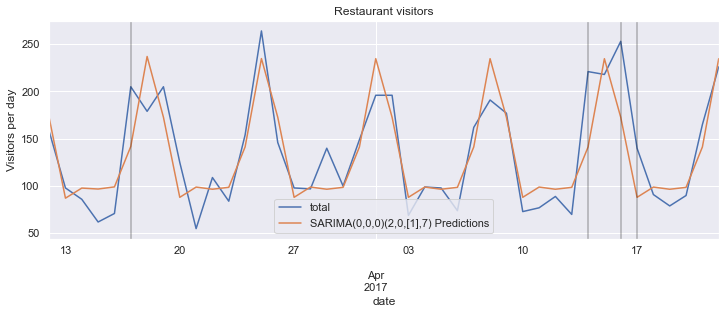

In [27]:
title = 'Restaurant visitors'
ylabel = 'Visitors per day'
ax = test['total'].plot(figsize = (12,4),title = title,legend = True)
predictions.plot(legend = True)
ax.autoscale(axis = 'x',tight = True)
ax.set(ylabel = ylabel)
for x in test.query("holiday==1").index:
    ax.axvline(x=x,color = 'k',alpha = 0.3)

In [28]:
error = rmse(test['total'],predictions)

print(f'SARIMAX RMSE: {error:0.3f}')

SARIMAX RMSE: 31.657


### now we add the exog variable

In [29]:
model = SARIMAX(train['total'],exog=train['holiday'], order = (0,0,0), seasonal_order=(2,0,[1],7),enforce_invertibility=False)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(2, 0, [1], 7)   Log Likelihood               -2098.257
Date:                   Wed, 17 Feb 2021   AIC                           4206.513
Time:                           18:16:59   BIC                           4226.902
Sample:                       01-01-2016   HQIC                          4214.560
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       69.8740      3.957     17.660      0.000      62.119      77.629
ar.S.L7        1.0458      0.055     19.142      0.000       0.939       1.153
ar.S.L14      -0.0459      0.055     -0.840      0.401      -0.153       0.061
ma.S.L7       -1.0407      0.026    -39.839      0.000      -1.092      -0.989
sigma2       746.4501     50.947     14.652      0.000     646.596     846.304
===================================================================================
Ljung-Box (Q):                       52.91   Jarque-Bera (JB):                20.75
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.23
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
start = len(train)
end = len(train) + len(test) - 1
exog_forecasts = test['holiday']
predictions = result.predict(start = start,end = end,exog= exog_forecasts).rename('SARIMAX(0,0,0)(2,0,[1],7) Predictions')


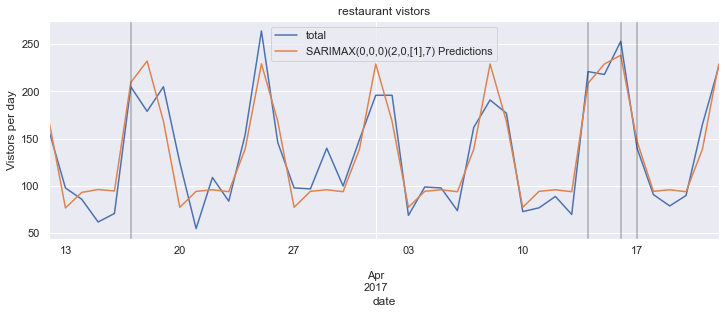

In [31]:
title = 'restaurant vistors'
ylabel = 'Vistors per day'

ax = test['total'].plot(figsize = (12,4),legend = True,title = title)
predictions.plot(legend = True)
ax.autoscale(axis = x,tight = True)
ax.set(ylabel = ylabel)

for x in test.query("holiday==1").index:
    ax.axvline(x = x,color = 'k',alpha = 0.3)

In [32]:
errorX = rmse(test['total'],predictions)
print(f'Sarimax exog error : {errorX :0.3f}')

Sarimax exog error : 22.864


In [37]:
len(df1)

478

## SARIMAX on the entire dataset

In [38]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(0,0,0),seasonal_order=(2,0,[1],7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:]['holiday']
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

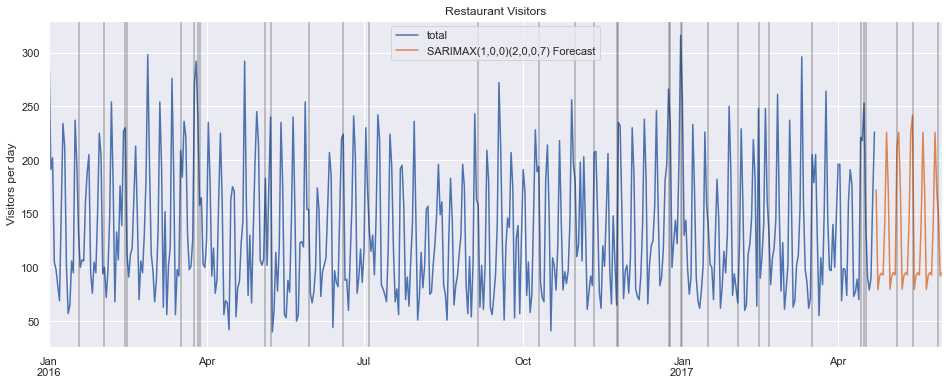

In [39]:

# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

# done!